# hydronetworks example
Quick example notebook to get started with the library.

## Basic setup
### Imports

In [1]:
from pathlib import Path

import folium
import matplotlib.pyplot as plt
from rasterio.plot import show as rioshow

from hydronetworks import HydroNetworks

### Helper functions

In [2]:
def plot(vec=None, ras=None, vmin=None, vmax=None, xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(3, 6))
    if ras is not None:
        rioshow(ras, cmap="Reds", vmin=vmin, vmax=vmax, ax=ax)
    if vec is not None:
        vec.to_crs(epsg=4326).plot(ax=ax)
    ax.axis("off")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

### File paths

In [3]:
in_path = Path("test_data")
out_path = Path("test_output")

rivers_path = in_path / "rivers.geojson"
dem_path = in_path / "dem.tif"
flow_path = in_path / "flow.tif"
flowacc_path = in_path / "flowacc.tif"

## Initialize the HydroNetworks object
And do some quick sanity checks

In [4]:
net = HydroNetworks(
    rivers_path=rivers_path,
    dem_path=dem_path,
    flow_path=flow_path,
    flowacc_path=flowacc_path,
)

DEM


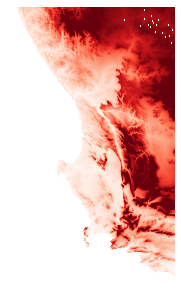

In [5]:
print("DEM")
plot(ras=net.dem, vmin=0, vmax=1000)

Now let's overlay the rivers and zoom in


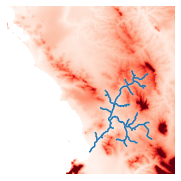

In [6]:
print("Now let's overlay the rivers and zoom in")
plot(ras=net.dem, vec=net.rivers, vmin=0, vmax=500, xlim=(18, 19), ylim=(-34, -33))

## Make the rivers network-aware
These will be the main data structures for holding the river network, and the nodes where rivers join. We'll also add the other data like elevation etc.

In [7]:
net.create_network()

Now we have a network of `arcs` (or `edges` if you prefer) and `nodes` from the river network. Each `arc` knows which `nodes` it has at each end (exactly two) and each `node` knows which `arcs` connect to it (at least one, for a source or mouth, and generally two or more).

An example of a single arc, showing its properties. `so` stands for stream-order, which it doesn't have yet!

In [8]:
def arc_deets(idx):
    labs = ["idx", "fx", "fy", "lx", "ly", "f-node", "l-node", "so", "length"]
    for l, v in zip(labs, net.network[idx].tolist()):
        print(f"{l}: {v}")


def node_deets(idx):
    labs = ["idx", "x", "y", "metadata", "arcs"]
    for l, v in zip(labs, net.nodes[idx][:4] + [net.nodes[idx][4:]]):
        print(f"{l}: {v}")

In [9]:
arc_deets(0)

idx: 0
fx: 2068687
fy: -3938277
lx: 2070774
ly: -3941876
f-node: 0
l-node: 25
so: -99
length: 4357


So now calculate Shreve stream order for the network. This allows to easily keep track of what is upstream and downstream.

In [10]:
net.assign_streamorder(method="shreve")

In [11]:
arc_deets(10)

idx: 10
fx: 2070774
fy: -3941876
lx: 2074948
ly: -3950187
f-node: 25
l-node: 21
so: 2
length: 10754


Now we have an `so` stream-order! Higher values indicate further down-stream.

And import elevation, gscd etc for each `node` (note: note into the `arcs`, as their location isn't so well-defined as the `nodes`!)

In [12]:
net.load_attributes()

Similarly to the `arcs`, the `nodes` each have a number of attributes:

In [13]:
node_deets(12)

idx: 12
x: 2082834
y: -3951572
metadata: {'elevation': 101, 'runoff': 41.762306, 'flow_acc': 102}
arcs: [6]


Convert to GeoDataFrames

In [14]:
net.network_to_gdf()

Now we have `rivers_out` and `nodes_out` that are `GeoDataFrames` and thus a bit easier to work with.

In [15]:
net.rivers_out.head(2)

,cartodb_id,arcid,up_cells,geometry,idx,xs,ys,xe,ye,node_start,node_end,so,length
0,773011,773011,233,"MULTILINESTRING ((18.58333 -33.50000, 18.59792...",0,2068687,-3938277,2070774,-3941876,0,25,1,4357
1,773386,773386,4101,"MULTILINESTRING ((18.62292 -33.63542, 18.62292...",1,2073093,-3956285,2072165,-3962386,11,93,12,7406


In [16]:
net.nodes_out.head(2)

,idx,x,y,elevation,runoff,flow_acc,arcs,geometry
0,0,2068687,-3938277,108,7.435320,27,[0],POINT (18.58333 -33.49999)
1,1,2070774,-3941876,88,20.093697,409,[],POINT (18.60208 -33.52708)


## Calculate local flow and hydro potential

In [17]:
net.local_flowacc()
net.calculate_hydro()

Now we've propagated streamflow down the network, accumulating as we go. The algorithm has also found us some potential hydropower sites!

In [18]:
net.hydro_points.sample(2)

,arcid,elevation,head,flowrate,power,geometry
95,772750,204,11,0.203264,10951.433983,POINT (18.83589 -33.40577)
34,773211,83,6,0.146234,4297.522350,POINT (18.69899 -33.59267)


## Let's see our river on a map!

In [19]:
hp = net.hydro_points.groupby("arcid").mean()
riv = net.rivers_out.join(other=hp, how="left", on="arcid", rsuffix="_hp")
riv = riv[["so", "flowrate", "geometry"]]
riv.flowrate = riv.flowrate.round(2)

In [20]:
m = folium.Map(location=(-33.7, 18.5), zoom_start=10)  # lat, lon
folium.GeoJson(
    riv,
    style_function=lambda ft: {"weight": 2 * ft["properties"]["so"] ** 0.5},
    tooltip=folium.GeoJsonTooltip(
        fields=["so", "flowrate"], aliases=["Streamorder", "Flowrate (m3/s)"]
    ),
).add_to(m)
m

## And save the output files

In [21]:
net.rivers_out.to_file(out_path / "arcs.geojson", driver="GeoJSON")
net.nodes_out.drop("arcs", axis=1).to_file(out_path / "nodes.geojson", driver="GeoJSON")
net.hydro_points.to_file(out_path / "hydro.geojson", driver="GeoJSON")